In [1]:
import pandas as pd 
import matplotlib. pyplot as plt 
import seaborn as sns
from matplotlib import style 
style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


/home/luo/anaconda3/envs/mdd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("/home/luo/projects/MDD/data/depress twitter english/depress_twitter_English.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [3]:
def data_preprocessing (text):
    if isinstance(text, float):
        text=''

    text = text.lower()
    text = re.sub(r"http\s+|www\S+http\S+", "",text,flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub("user",'',text)
    text = re.sub("url",'',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [4]:
df.text = df["tweet"].apply(data_preprocessing)
df.head()

/tmp/ipykernel_3475104/1806502255.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.text = df["tweet"].apply(data_preprocessing)


,tweet,label
0,I just don’t take my baby out because it gives...,1
1,Suicide figures are up 200% since lockdown. \n...,1
2,she has really been feeding us this week https...,0
3,"I can confirm that yes, I do need to stay on m...",1
4,"Today is pie day! Celebrate with your ""I Ate P...",0


<Axes: xlabel='label', ylabel='count'>

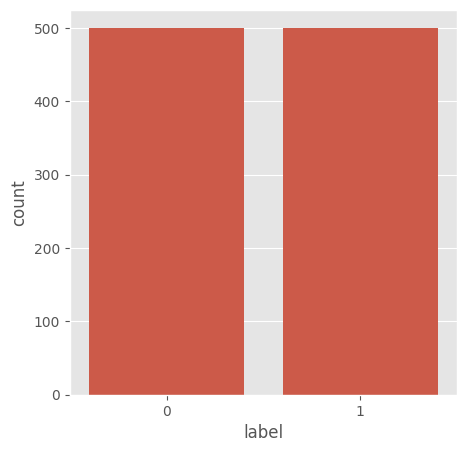

In [5]:

df.text = df["tweet"].apply(data_preprocessing)
df = df.drop_duplicates('tweet')
df['label'].value_counts()
fig = plt.figure(figsize=(5,5))
sns.countplot(x = 'label', data=df)

In [6]:
import numpy as np

from scipy.special import softmax

In [8]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import softmax

# Load tokenizer and model
MODEL = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Load the dataset

# Create lists to store predictions and true labels
predicted_labels = []
true_labels = df['label'].tolist()  # Assuming 'true_label' is the column name for true labels

# Inspect the model to find the number of labels it predicts
num_labels = model.config.num_labels

# Define the label mapping (assuming 0: 'not depression', 1: 'depression')
# Adjust this mapping if your model uses different indices
labels = {i: i for i in range(num_labels)}

# Iterate through the DataFrame and make predictions
for index, row in df.iterrows():
    text = row['tweet']
    true_label = row['label']

    # Tokenize and make predictions
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    output = model(**encoded_input)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)

    # Get predicted label
    predicted_label_index = np.argmax(scores)
    predicted_label = labels[predicted_label_index]

    # Store predicted labels
    predicted_labels.append(predicted_label)

# Add the predicted labels to the DataFrame
df['predicted_sentiment'] = predicted_labels

# Calculate accuracy and F1 score
cm = classification_report(true_labels,predicted_labels)
print(cm)


              precision    recall  f1-score   support

           0       0.41      0.33      0.36       500
           1       0.44      0.53      0.48       500

    accuracy                           0.43      1000
   macro avg       0.43      0.43      0.42      1000
weighted avg       0.43      0.43      0.42      1000

